# 03 - QUEEN-NOQUEEN - SVM Classification

## Prerequisites

- The dataset exists (if not, execute 00 - Dataset Initialisation)
- The dataset features have been populated (if not, execute 02 - Features Computation)


In [5]:
import warnings                              # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')            # commented out till the experiment final version,
                                             # in order to avoid missing "real" warnings 
from IPython.display import display
import kilroy_was_here                       # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import iprint
from audace.audiodataset import AudioDataset # Main class for audio dataset handling

# Experiment name will be used to prefix potential outputs
EXP_NAME = "03 - QUEEN-NOQUEEN - SVM Classification"

# Dataset name is the master key for dataset adressing
# Change it according to the dataset you want to process
DATASET_NAME = 'MMAIN1000'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Display cardinalities by hive attribute and queen label for samples with no external perturbation
sql = """
    select distinct hive, queen, count(*)
    from samples
    where nobee = 0
    group by hive, queen
    order by hive
    """
display(ds.queryDataFrame(sql))

[2020-08-29/14:55:11.863|23.1%|78.9%|0.42GB] ------------------------------------------------------
[2020-08-29/14:55:11.864|00.0%|78.9%|0.42GB] DATASET NAME          : MMAIN1000
[2020-08-29/14:55:11.864|00.0%|78.9%|0.42GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MMAIN1000
[2020-08-29/14:55:11.864|00.0%|78.9%|0.42GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MMAIN1000\MMAIN1000.db
[2020-08-29/14:55:11.865|80.0%|78.9%|0.42GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MMAIN1000\samples
[2020-08-29/14:55:11.865|00.0%|78.9%|0.42GB] NB SOURCE AUDIO FILES : 48
[2020-08-29/14:55:11.865|00.0%|78.9%|0.42GB] SAMPLE RATE           : 22050
[2020-08-29/14:55:11.865|00.0%|78.9%|0.42GB] DURATION              : 1.0
[2020-08-29/14:55:11.865|00.0%|78.9%|0.42GB] OVERLAP               : 0.0
[2020-08-29/14:55:11.866|00.0%|78.9%|0.42GB] NB AUDIO CHUNKS       : 24788
[2020-08-29/14:55:11.866|00.0%|78.9%|0.42GB] ------------------------------------------------------


,hive,queen,count(*)
0,CF001,0.0,14
1,CF003,1.0,3649
2,CJ001,0.0,790
3,GH001,1.0,1396
4,Hive1,0.0,1473
5,Hive1,1.0,2684
6,Hive3,0.0,6545
7,Hive3,1.0,654


In [2]:
ds.listFeatures()

['api180_185_1',
 'api180_190_5',
 'api180_225_1',
 'apidictor',
 'emph_mfcc20',
 'jpg00',
 'mfcc20',
 'mfcc8',
 'std_apidictor',
 'std_mfcc20',
 'std_mfcc8']

In [6]:
import numpy as np
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from audace.jupytools import predestination
from audace.audiodataset import serie_to_2D

# Experiment parameters
FEATURE_NAME = 'mfcc20'
SET_FRAC = 1
TEST_FRAC = 0.3
KERNEL = 'rbf'
C = 1
GAMMA = 'scale'

# Seed the various PRNGs
predestination()

# Get pandas dataframe containing the columns we will need for this experiment,
# shuffle it (and potentially truncate it to speed quick tests)
iprint(">>>>> Query features and labels")
sql = F"select {FEATURE_NAME}, queen from samples where nobee = 0"
df = ds.queryDataFrame(sql).sample(frac=SET_FRAC)

# flatten features array
#iprint(">>>>> Flatten features")
X = serie_to_2D(df[FEATURE_NAME])
#s = df[FEATURE_NAME]
#X = np.stack(s)[:,0,:]
#print("x", x.shape)
print("X", X.shape)


# get labels
y = df['queen']

# Partition dataset into training and test subsets
iprint(">>>>> Partition training/test")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC)

# It is usually a good idea to scale the data for SVM training. Classifiers usually
#perform better on standardized data
iprint(">>>>> Scale")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create a svm Classifier, using the experiment parameters
clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

#Train the model using the training sets
iprint('>>>>> Train')
clf.fit(X_train, y_train)

#Predict the response for test dataset
iprint('>>>>> Predict')
y_pred = clf.predict(X_test)

# Display information about the classifier performance
iprint(F"Trained over {len(y_train)} / Tested over {len(y_test)}")
iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
iprint("Precision :",metrics.precision_score(y_test, y_pred))
iprint("Recall    :",metrics.recall_score(y_test, y_pred))
iprint("F-Measure :",metrics.f1_score(y_test, y_pred))


[2020-08-29/14:55:18.721|15.3%|79.0%|0.42GB] >>>>> Query features and labels
X (17205, 880)
[2020-08-29/14:55:19.263|31.8%|80.1%|0.48GB] >>>>> Partition training/test
[2020-08-29/14:55:19.304|27.3%|80.6%|0.53GB] >>>>> Scale
[2020-08-29/14:55:19.730|39.3%|80.8%|0.53GB] >>>>> Train
[2020-08-29/14:55:48.576|27.0%|81.1%|0.54GB] >>>>> Predict
[2020-08-29/14:55:59.865|27.4%|81.3%|0.54GB] Trained over 12043 / Tested over 5162
[2020-08-29/14:55:59.867|00.0%|81.3%|0.54GB] Accuracy  : 0.9843084075939559
[2020-08-29/14:55:59.871|00.0%|81.3%|0.54GB] Precision : 0.99
[2020-08-29/14:55:59.875|00.0%|81.3%|0.54GB] Recall    : 0.9778743579612801
[2020-08-29/14:55:59.879|00.0%|81.3%|0.54GB] F-Measure : 0.9838998211091233


In [17]:
print(FEATURE_NAME)

for hive in ds.listAttributeValues('hive'):
    hive_df = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = '{hive}'").sample(frac=1)
    X = np.stack(hive_df[FEATURE_NAME])[:,0,:]
    #hive_X = scaler.transform(feature_serie_to_flat_np())
    hive_X = scaler.transform(X)
    hive_y = hive_df['queen']
    hive_y_pred = clf.predict(hive_X)
    print(hive, metrics.accuracy_score(hive_y, hive_y_pred))
    



mfcc20
CF001 1.0
GH001 0.6446991404011462
CF003 0.9862976157851466
CJ001 0.8962025316455696
Hive1 0.8253548231898004
Hive3 0.7175996666203639


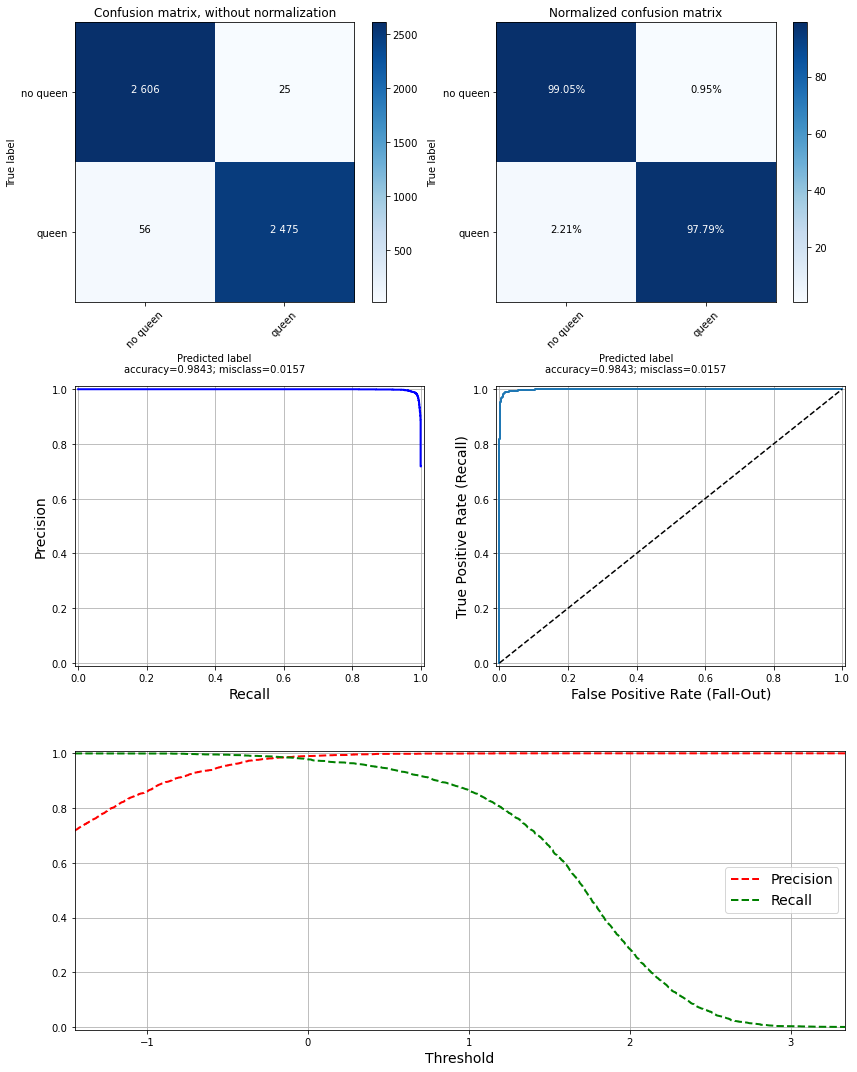

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    no queen       0.98      0.99      0.98      2631
       queen       0.99      0.98      0.98      2531

    accuracy                           0.98      5162
   macro avg       0.98      0.98      0.98      5162
weighted avg       0.98      0.98      0.98      5162

------------------------------------------------------------------------------------------
Area Under ROC Curve 0.9989058517409588
------------------------------------------------------------------------------------------


In [7]:
from audace.plotters import clf_full_report
from sklearn import metrics

target_names = ['no queen', 'queen']

tst = int(100*TEST_FRAC)
trn = 100 -tst

figure_name = F"Full Report {KERNEL} - ({DATASET_NAME}) - [Trn{trn:02d},Tst{tst:02d}] - C{C}"
if KERNEL != 'linear':
    figure_name += F" - G{GAMMA}"

clf_full_report(clf, X_test, y_test, target_names, EXP_NAME, figure_name)


print("------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred , target_names=target_names))
print("------------------------------------------------------------------------------------------")
print('Area Under ROC Curve', metrics.roc_auc_score(y_test, clf.decision_function(X_test)))
print("------------------------------------------------------------------------------------------")

-------------------------------------
Accuracy: 0.3228289631946115
Precision: 0.13812154696132597
Recall: 0.009314456035767511
F1: 0.017452006980802792


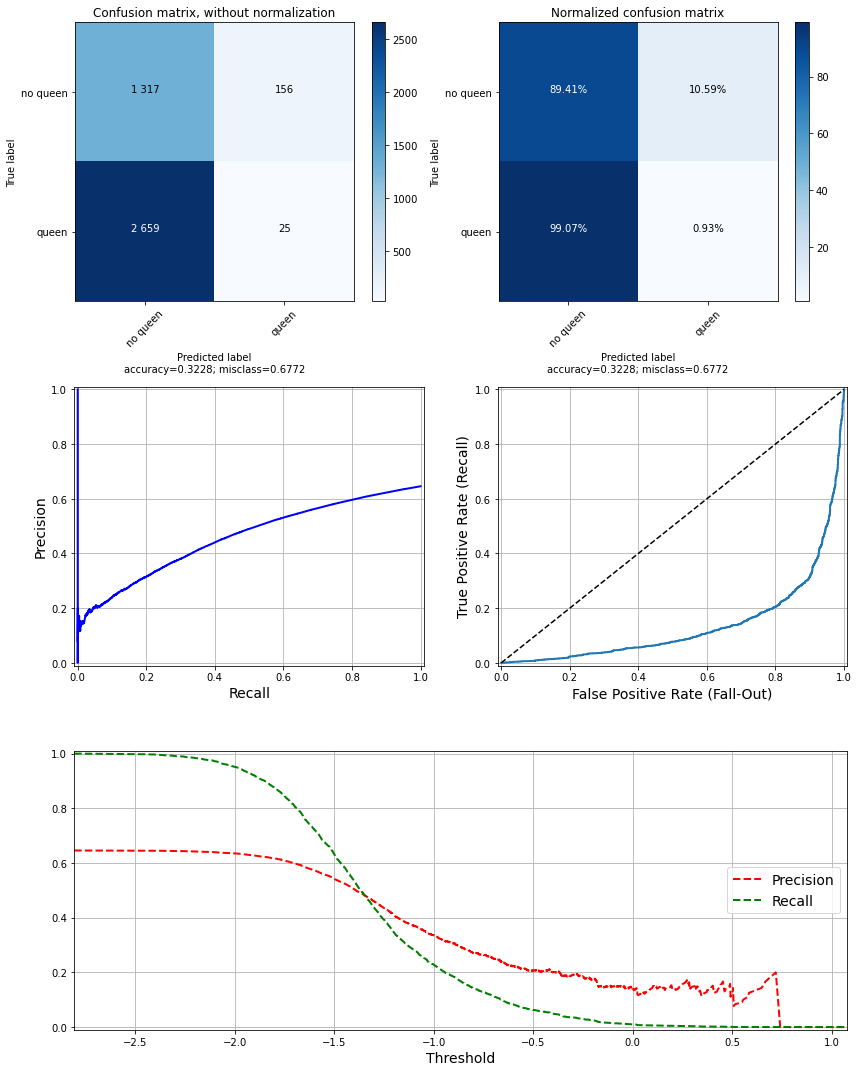

-------------------------------------
Accuracy: 0.31643283789415194
Precision: 0.0021003500583430573
Recall: 0.013761467889908258
F1: 0.0036444624417898363


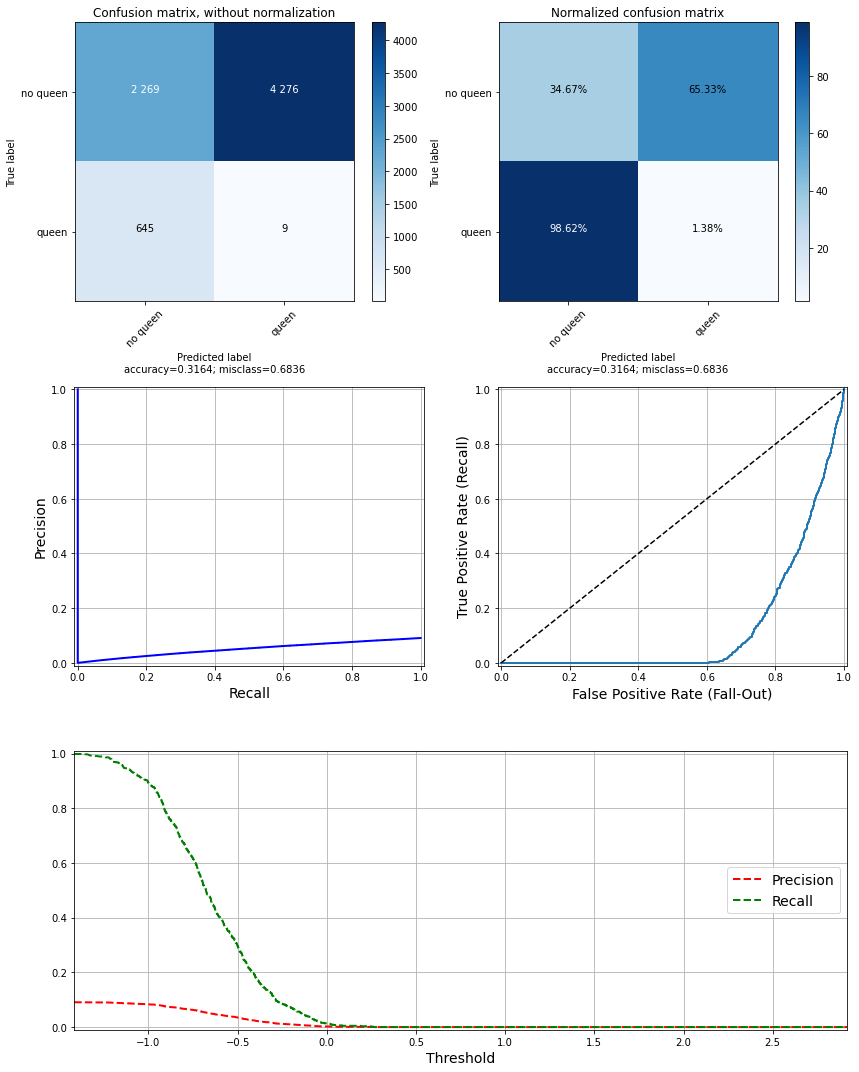

In [8]:
from sklearn import svm
from sklearn import metrics
from audace.plotters import clf_full_report
from sklearn.preprocessing import StandardScaler

FEATURE_NAME = 'mfcc20'
KERNEL = 'rbf'
C = 1
GAMMA = 'scale'
TRAIN_FRAC = 1
target_names = ['no queen', 'queen']


df_fold1 = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = 'Hive3'").sample(frac=1)
df_fold2 = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = 'Hive1'").sample(frac=1)


def process_svm(X_train_serie, y_train, X_test_serie, y_test):
    X_train = serie_to_2D(X_train_serie)
    X_test = serie_to_2D(X_test_serie)
    
    #X_train = np.stack(X_train_serie)[:,0,:]
    #X_test= np.stack(X_test_serie)[:,0,:]

    #Create a svm Classifier
    clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

    scaler = StandardScaler()    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
    
    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("-------------------------------------")
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("F1:",metrics.f1_score(y_test, y_pred))
    
    return clf, X_test, y_test


df_train = df_fold1.sample(frac = TRAIN_FRAC)
df_test = df_fold2

c, X, y = process_svm(df_train[FEATURE_NAME], df_train['queen'], df_test[FEATURE_NAME], df_test['queen'])
clf_full_report(c, X, y, target_names)

df_train = df_fold2.sample(frac = TRAIN_FRAC)
df_test = df_fold1
c, X, y = process_svm(df_train[FEATURE_NAME], df_train['queen'], df_test[FEATURE_NAME], df_test['queen'])
clf_full_report(c, X, y, target_names)

